# Next Frame Prediction with CNN-LSTM 

Reference link - https://www.kaggle.com/kcostya/convlstm-convolutional-lstm-network-tutorial

Ashwin U Iyer
19BAI1118

In [1]:
import tensorflow as tf
from keras.models import modeluential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adadelta
import numpy as np
import pylab as plt

In [2]:
model = modeluential()

model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_modeluences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                   padding='same', return_modeluences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                   padding='same', return_modeluences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                   padding='same', return_modeluences=True))
model.add(BatchNormalization())

model.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))

model.compile(loss='mse', optimizer='sgd')

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 40, 40, 64)  150016    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 40, 40, 64)  256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 40, 40, 32)  110720    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40, 40, 32)  128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 40, 40, 32)  73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40, 40, 32)  128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 40, 40, 32)  7

In [4]:
def makeMovie(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisyMovie = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shiftedMovie = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisyMovie[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisyMovie[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shiftedMovie[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisyMovie = noisyMovie[::, ::, 20:60, 20:60, ::]
    shiftedMovie = shiftedMovie[::, ::, 20:60, 20:60, ::]
    noisyMovie[noisyMovie >= 1] = 1
    shiftedMovie[shiftedMovie >= 1] = 1
    return noisyMovie, shiftedMovie

In [5]:
noisyMovie, shiftedMovie = makeMovie()

In [6]:
noisyMovie.shape, shiftedMovie.shape

((1200, 15, 40, 40, 1), (1200, 15, 40, 40, 1))

In [7]:
model.fit(noisyMovie[:1000], shiftedMovie[:1000], batch_size=8,
        epochs=10, validation_split=0.05)

Epoch 1/10
119/119 [==============================] - 106s 663ms/step - loss: 0.1983 - val_loss: 0.1601
Epoch 2/10
119/119 [==============================] - 76s 637ms/step - loss: 0.1037 - val_loss: 0.0803
Epoch 3/10
119/119 [==============================] - 83s 699ms/step - loss: 0.0725 - val_loss: 0.0563
Epoch 4/10
119/119 [==============================] - 92s 773ms/step - loss: 0.0479 - val_loss: 0.0538
Epoch 5/10
119/119 [==============================] - 75s 633ms/step - loss: 0.0291 - val_loss: 0.0406
Epoch 6/10
119/119 [==============================] - 76s 642ms/step - loss: 0.0214 - val_loss: 0.0203
Epoch 7/10
119/119 [==============================] - 78s 655ms/step - loss: 0.0179 - val_loss: 0.0158
Epoch 8/10
119/119 [==============================] - 76s 640ms/step - loss: 0.0151 - val_loss: 0.0132
Epoch 9/10
119/119 [==============================] - 73s 614ms/step - loss: 0.0133 - val_loss: 0.0118
Epoch 10/10
119/119 [==============================] - 76s 637ms/step - 

In [8]:
which = 1004
track = noisyMovie[which][:7, ::, ::, ::]

In [9]:
track.shape, track[np.newaxis, ::, ::, ::, ::].shape

((7, 40, 40, 1), (1, 7, 40, 40, 1))

In [10]:
for j in range(16):
    new_pos = model.predict(track[np.newaxis, ::, ::, ::, ::]) # (1, 7, 40, 40, 1)
    new = new_pos[::, -1, ::, ::, ::] # (1, 40, 40, 1)
    track = np.concatenate((track, new), axis=0) # adds +1 to the first dimension in each loop cycle

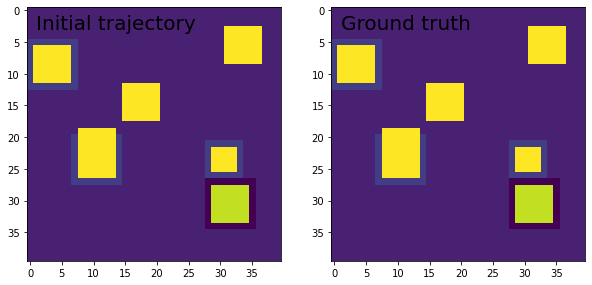

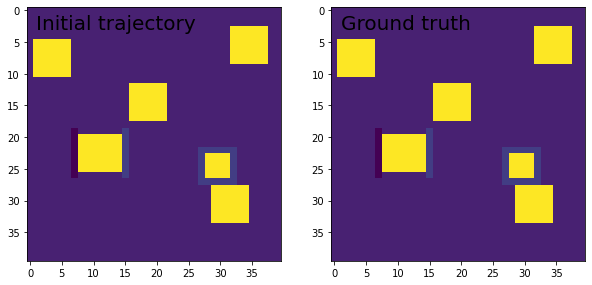

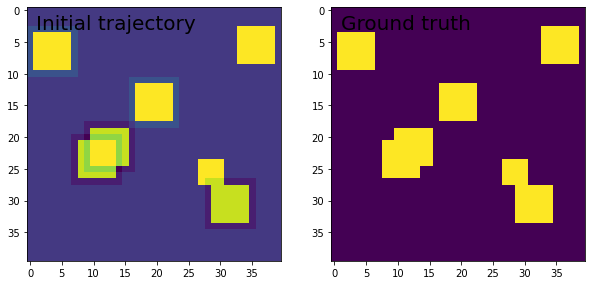

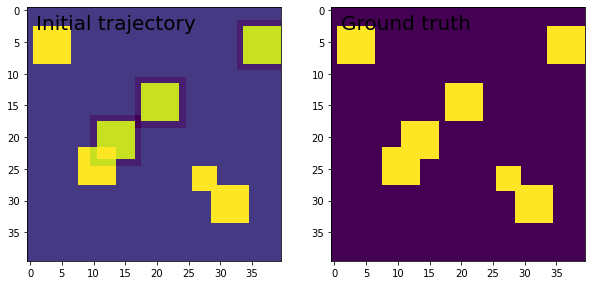

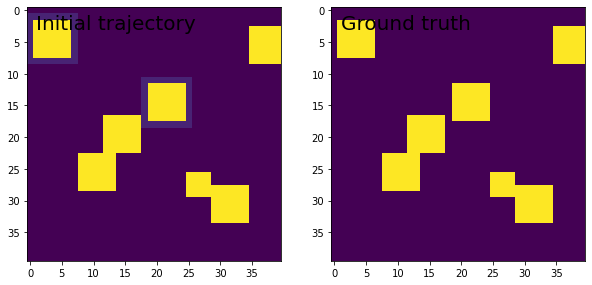

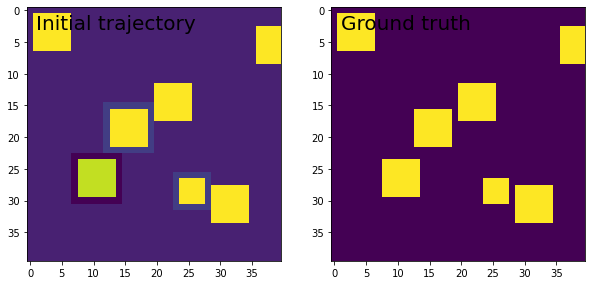

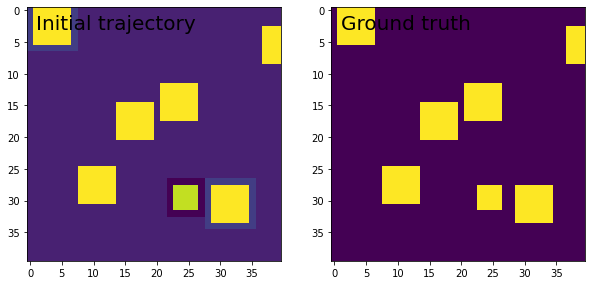

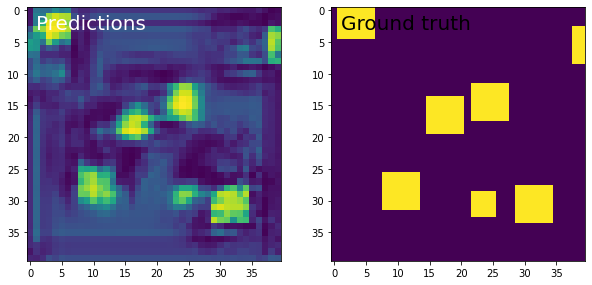

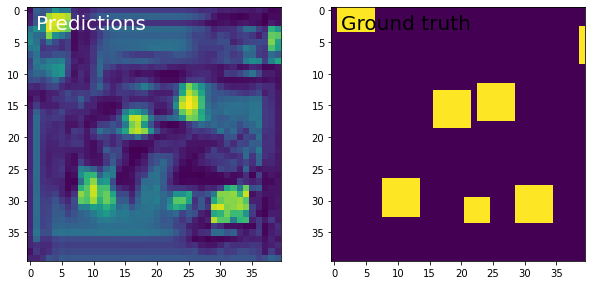

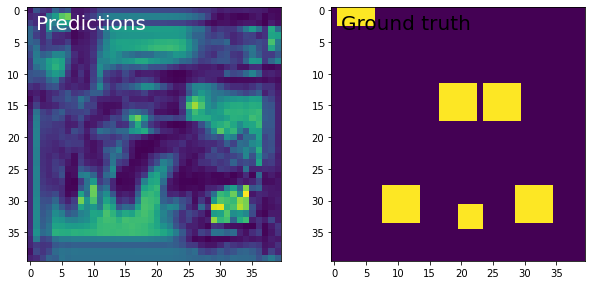

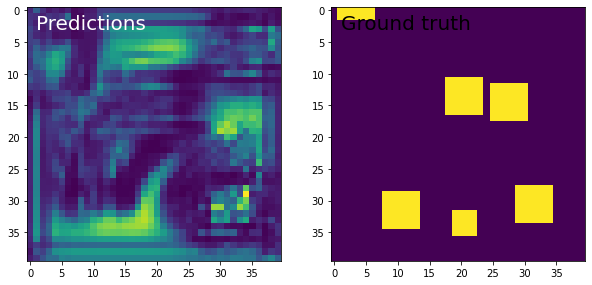

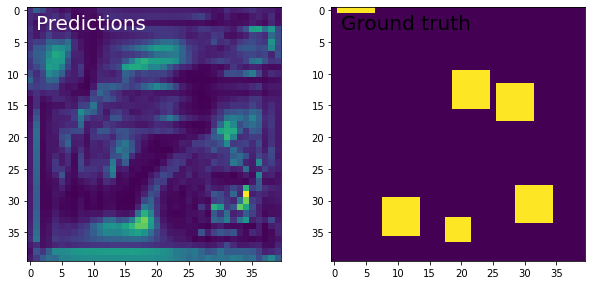

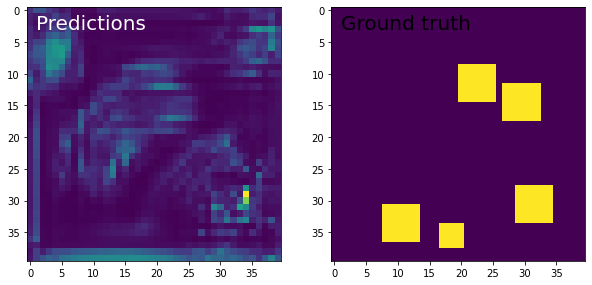

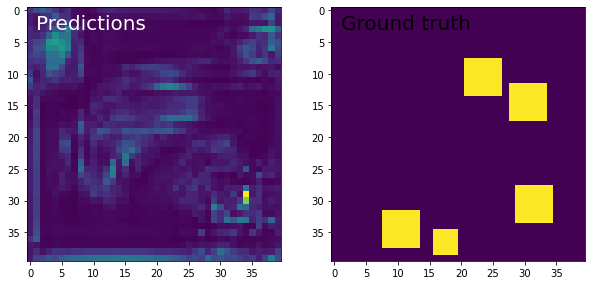

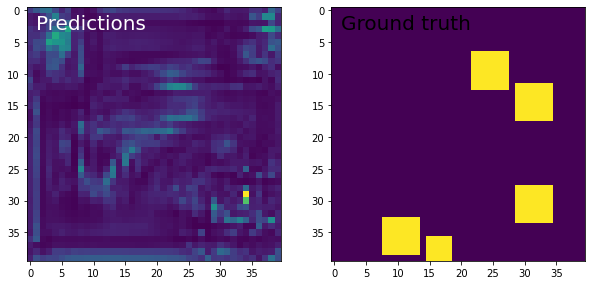

In [11]:
track2 = noisyMovie[which][::, ::, ::, ::]

for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shiftedMovie[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))